# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных:**

Признаки
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

Целевой признак
* Price — цена (евро)

## Подготовка и анализ данных

In [71]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score

from tqdm import tqdm
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

In [2]:
# Сохраняем информацию файла в датафрейме data
data = pd.read_csv('/datasets/autos.csv')
data.head() # Выводим первые строки на экран для ознакомления

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
# Выводим общую информацию о датафрейме
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

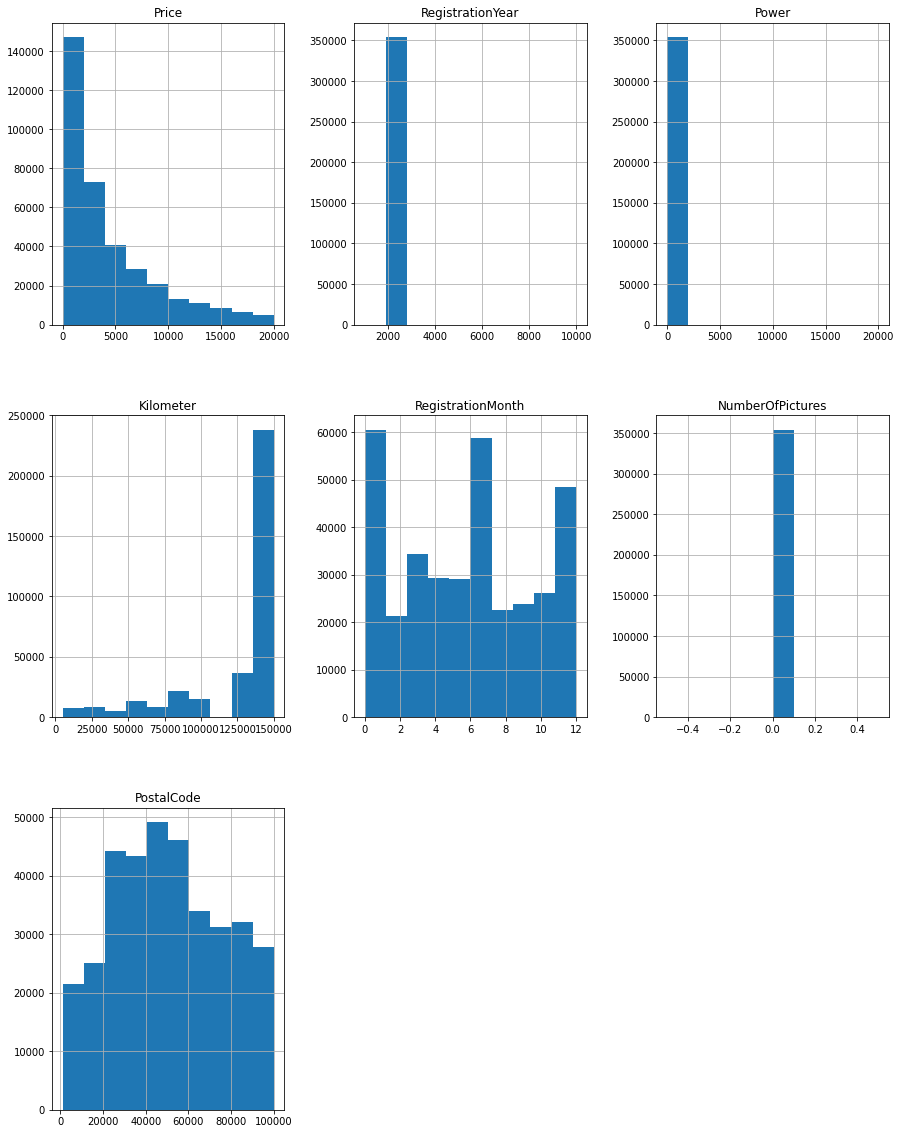

In [4]:
# Строим гистограммы, чтобы нагляднее прикоснуться к данным
data.hist(figsize=(15, 20))
None

In [5]:
# Более подробно смотрим на распределение значений 
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [6]:
# Оцениваем, как признаки коррелируют друг с другом
data.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000


In [7]:
# Смотрим количество пропущенных значений
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [8]:
# Проверяем на наличие явных дубликатов
data.duplicated().sum()

4

### Вывод

На основе некатегориальных признаков можно следать следующие выводы, иллюстрированные на гистрограммах:
* Автомобили в основном стоят до 5000 евро;
* В среднем, имеют около 110 л.с.;
* Более 125 тыс. км. пробега;

На основе проведенного анализа данных видим:
* Пропущено много значений в пяти разных столбцах;
* Есть 4 дубликата, которые необходимо убрать;
* Столбцы, связанные с данными пользователя и анкетой, тоже необходимо убрать, т.к. они нам ни к чему в обучении моделей;
* Типы данных корректны;
* Наименования столбцов также имеют корректный вид. Можно было бы привести их к змеиному регистру, но их нынешний вид тоже вполне удобен.
* Признаки друг с другом практически никак не коррелируют;
* Имеются аномальные значения в стобцах с годом регистрации и мощностью автомобиля.

### Предобработка данных

Со столбцом, отображающим, была ли машина в ремонте, все проще всего. Скорее всего, пропуски в нем свидетельствуют о том, что он (ремонт) не осуществлялся. Поэтому заполним их значением `'no'`.

In [9]:
data['NotRepaired'] = data['NotRepaired'].fillna('no')

Убирать остальные пропуски исключением их из датафрейма было бы опрометчиво, т.к. были бы значительные потери. Но и заполнить средним значением их не выйдет, т.к. по большей части признаки у нас категориальные.
Самым верным вариантом считаю - заполнение пропусков наиболее часто встречающимся значением.

In [10]:
data['VehicleType'] = data['VehicleType'].fillna(data['VehicleType'].mode()[0])
data['Gearbox'] = data['Gearbox'].fillna(data['Gearbox'].mode()[0])
data['Model'] = data['Model'].fillna(data['Model'].mode()[0])
data['FuelType'] = data['FuelType'].fillna(data['FuelType'].mode()[0])

In [11]:
# Убираем дубликаты
data = data.drop_duplicates()
data.duplicated().sum() # Проверяем

0

In [12]:
# Убираем ненужные нам при обучении столбцы
data.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures', 'PostalCode'], axis = 1, inplace=True)

In [13]:
data['Price'].value_counts()

0        10772
500       5670
1500      5394
1000      4648
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: Price, Length: 3731, dtype: int64

Видим очень много автомобилей с нулевой ценой. Можно было бы заполнить их средним или медианой, но, думаю, это исказит нашу выборку, поэтому придется их исключить.

In [14]:
data = data.query('Price > 0')

Теперь приступим к обработке выбросов.
Чтобы не исключать их и не терять ценные данные - приравняем их к более реальным значениям, понимая, что младше 2022 года автомобиль быть не может и едва ли он будет старше 1950, если только это не редкая коллекционная модель.

In [15]:
data.loc[data['RegistrationYear'] > 2022, 'RegistrationYear'] = 2022 # Устанавливаем верхнее ограничение
data.loc[data['RegistrationYear'] > 1950, 'RegistrationYear'] = 1950 # Устанавливаем нижнее ограничение

То же самое проделаем с мощностью.
Поискав информацию в интернете, пришел к выводу, что серийные автомобили могут иметь мощность менее 2000 л.с.
Ограничим потолок именно этим значением.

In [16]:
data.loc[data['Power'] > 2000, 'Power'] = 2000 # Ограничиваем потолок мощности

In [17]:
data.info() # Проверяем еще раз после предобработки

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343592 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              343592 non-null  int64 
 1   VehicleType        343592 non-null  object
 2   RegistrationYear   343592 non-null  int64 
 3   Gearbox            343592 non-null  object
 4   Power              343592 non-null  int64 
 5   Model              343592 non-null  object
 6   Kilometer          343592 non-null  int64 
 7   RegistrationMonth  343592 non-null  int64 
 8   FuelType           343592 non-null  object
 9   Brand              343592 non-null  object
 10  NotRepaired        343592 non-null  object
dtypes: int64(5), object(6)
memory usage: 31.5+ MB


## Обучение моделей

### Разделение данных на выборки

Так как у нас много категориальных признаков - преобразуем их прямым кодированием.

In [18]:
# data_ohe = pd.get_dummies(data, drop_first=True) # Используем метод OHE

# target = data_ohe['Price'] # Создаем переменную с признаками
# features = data_ohe.drop('Price', axis=1) # Создаем переменную с целевым признаком

In [19]:
# # Выполняем разделение на тренировочную и тестовую выборку в соотношении 75:25
# (train_features,
# test_features,
# train_target,
# test_target) = train_test_split(features, target, test_size=0.25, random_state=12345)

# # Проверяем
# print(train_features.shape)
# print(test_features.shape)
# print(train_target.shape)
# print(test_target.shape)
# print(train_features.shape[0]/features.shape[0], test_features.shape[0]/features.shape[0])

In [20]:
features = data.drop('Price', axis=1) # Выделяем признаки в отдельную переменную
target = data['Price'] # Создаем переменную с признаками

encoder = OrdinalEncoder() # Проводим прямое кодировние

cat_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
cat_features = features[cat_columns] # Создаем массив с категориальными столбцами
cat_features = pd.DataFrame(encoder.fit_transform(cat_features),
                                    columns=cat_features.columns, 
                                    index=cat_features.index)

ordinal_features = features.copy()
for i in cat_columns: # Передаем кодирование тех же столбцов переменной ordinal_features
    ordinal_features[i] = cat_features[i]

In [21]:
data_ohe = pd.get_dummies(data, drop_first=True) # Используем метод OHE
features_ohe = data_ohe.drop('Price', axis=1) # Создаем переменную с целевым признаком

In [22]:
# Выполняем разделение на выборки
(features_train,
 features_test,
 target_train,
 target_test) = train_test_split(features, target, test_size=0.25, random_state=12345)

ordinal_features_train = ordinal_features.loc[features_train.index, :]
ordinal_features_test = ordinal_features.loc[features_test.index, :]

features_ohe_train = features_ohe.loc[features_train.index, :]
features_ohe_test = features_ohe.loc[features_test.index, :]

### RandomForestRegressor

In [23]:
%%time
# Модель RandomForest
# задаем параметры и сохраняем в переменной
RF_model = RandomForestRegressor(criterion = 'mse', random_state=12345, n_estimators = 100)
RF_model.fit(ordinal_features_train, target_train) # Обучаем

CPU times: user 55.2 s, sys: 803 ms, total: 56 s
Wall time: 56.1 s


RandomForestRegressor(random_state=12345)

### CatBoostRegressor

In [24]:
%%time
# Модель CatBoost
# Аналогично случайному лесу - задаем параметры и проводим обучение
cbr_model = CatBoostRegressor()
hyperparams_cat = [{'learning_rate':[0.1, 0.5, 0.8],
                'random_state':[12345],
                'depth':[5,10]}]

cbr_grid = GridSearchCV(cbr_model, hyperparams_cat, scoring='neg_mean_squared_error')
cbr_grid.fit(ordinal_features_train, target_train)

0:	learn: 4290.1958827	total: 76.8ms	remaining: 1m 16s
1:	learn: 4099.0707127	total: 101ms	remaining: 50.6s
2:	learn: 3935.8517151	total: 124ms	remaining: 41.4s
3:	learn: 3785.2727698	total: 148ms	remaining: 37s
4:	learn: 3666.1256677	total: 171ms	remaining: 34s
5:	learn: 3558.2988664	total: 193ms	remaining: 32s
6:	learn: 3466.2003347	total: 217ms	remaining: 30.8s
7:	learn: 3384.9230697	total: 239ms	remaining: 29.7s
8:	learn: 3313.6219069	total: 262ms	remaining: 28.8s
9:	learn: 3253.4143389	total: 285ms	remaining: 28.2s
10:	learn: 3199.4396105	total: 307ms	remaining: 27.6s
11:	learn: 3152.3733829	total: 330ms	remaining: 27.2s
12:	learn: 3112.2985670	total: 356ms	remaining: 27s
13:	learn: 3077.8398877	total: 378ms	remaining: 26.6s
14:	learn: 3047.7340261	total: 401ms	remaining: 26.3s
15:	learn: 3021.8532902	total: 423ms	remaining: 26s
16:	learn: 2994.6338577	total: 449ms	remaining: 25.9s
17:	learn: 2973.1497413	total: 470ms	remaining: 25.7s
18:	learn: 2953.0947962	total: 493ms	remaining

GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x7f68aaf38e80>,
             param_grid=[{'depth': [5, 10], 'learning_rate': [0.1, 0.5, 0.8],
                          'random_state': [12345]}],
             scoring='neg_mean_squared_error')

In [25]:
print(cbr_grid.best_params_) # Смотрим лучшие

{'depth': 10, 'learning_rate': 0.5, 'random_state': 12345}


### LightGBM

In [40]:
%%time

lgbm_model = LGBMRegressor() 
hyperparams_lgbm = [{'num_leaves':[31, 100, 200], 
                     'learning_rate':[0.1, 0.3, 0.5],
                     'random_state':[12345]}]

clf = GridSearchCV(lgbm_model, hyperparams_lgbm, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print(clf.best_params_)
means = clf.cv_results_['mean_test_score']

cross_lgbm = (max(means)*-1) ** 0.5

print(cross_lgbm)

{'learning_rate': 0.3, 'num_leaves': 200, 'random_state': 12345}
2112.069958035912
CPU times: user 25min 8s, sys: 17.3 s, total: 25min 25s
Wall time: 25min 36s


In [67]:
# %%time
# Модель LightGBM
# Добавил сюда try-exept, т.к. при переборе параметров почему-то часто получал 'ядро умро'
# try:
#     train_lgbm = lgb.Dataset(ordinal_features_train, target_train)
#     test_lgbm = lgb.Dataset(ordinal_features_test, target_test, reference=train_lgbm)
#     hyperparams_lgbm = {'metric': 'rmse', 'max_depth': 10, 'random_state': 42, 'learning_rate': 0.1}
#     lgbm_model = lgb.train(hyperparams_lgbm,
#                            train_lgbm,
#                            num_boost_round=1000,
#                            valid_sets=[train_lgbm, test_lgbm],
#                            verbose_eval=100)
# except:
#     print('Ядро умерло')

In [28]:
# %%time
# # Делаем предсказания моделей и сразу вычисляем метрику RMSE у каждой из моделей
# print('LightGBM:' lgbm_model.predict(ordinal_features_test)))**0.5)

In [78]:
# %%time
# print('RandomForest:', mean_squared_error(target_test, RF_model.predict(ordinal_features_test))**0.5)

In [30]:
# %%time
# print('CatBoost:', mean_squared_error(target_test, cbr_grid.predict(ordinal_features_test))**0.5)

In [49]:
catboost = CatBoostRegressor(learning_rate=0.5,
                              iterations = 200,
                              random_state=12345, 
                              verbose=False, 
                              cat_features=['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']) 

cross_cat = (cross_val_score(catboost, 
                             features_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_root_mean_squared_error').mean()*-1)

In [63]:
cross_RF = (cross_val_score(RF_model,
                            ordinal_features_train, 
                            target_train, 
                            cv=5,
                            scoring='neg_root_mean_squared_error').mean()*-1)

In [64]:
print('Среднее RMSE CatBoost =', cross_cat)
print('RMSE LGBM =', cv_RMSE_LGBMR)
print('RMSE RF =', cross_RF)

Среднее RMSE CatBoost = 2229.2688189918067
RMSE LGBM = 2112.069958035912
RMSE RF = 2201.237844814377


In [68]:
# Создаем таблицу, чтобы было удобно анализировть полученные результаты

# time_RF = mean_squared_error(test_target, RF_model.predict(test_features))**0.5
# time_LGBM = mean_squared_error(test_target, lgbm_model.predict(test_features))**0.5
# time_CBR = mean_squared_error(test_target, cbr_grid.predict(test_features))**0.5

analys_data = {'Models': ['RandomForest', 'CatBoost', 'LightGBM'],
               'RMSE': [cross_RF, cross_cat, cross_lgbm],
               'Время обучения': ['56.1s', '20min 30s', '25min 36s']}
analys_data = pd.DataFrame(analys_data)

## Анализ моделей

Цель, поставленная заказчиком - построить модель, способную предсказывать рыночную стоимость автомобилей.

Главные критерии оценки:
* качество предсказания;
* время обучения модели;
* время предсказания модели.

При этом метрика RMSE не должна быть более 2500.

По результатам обучения и предсказания видим следующие показатели:

In [69]:
display(analys_data)

,Models,RMSE,Время обучения
0,RandomForest,2201.237845,56.1s
1,CatBoost,2229.268819,20min 30s
2,LightGBM,2112.069958,25min 36s


На основе полученных таблицей данных можно сделать следующие выводы:
* Разброс метрики среди моделей не сильно большой, но наименьшее значение ошибки у модели LightGBM;
* Но LightGBM при этом обучается дольше всех;
* RandomForest обучился быстрее всех и занял второе место по значению RMSE;

Исходя из этого можно сделать вывод, что по соотношению затраченного на обучение времени и полученного результата - выигрывает RandomForest. Его мы и протестируем.

In [81]:
%%time

print(mean_squared_error(target_test, RF_model.predict(ordinal_features_test))**0.5)

2167.6963123843084
CPU times: user 3.64 s, sys: 24.4 ms, total: 3.67 s
Wall time: 3.67 s


Получаем значение метрики RMSE в `2167` при времени обучения `56.1s` и времени предсказания `3.67`. 